## Music Classification
The main features that will be used to determine the similarity between two songs will be temp of the songs and when beats occur, the percussive rythm, and the sequence of notes played

In [2]:
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [3]:
from __future__ import print_function
import librosa

# 1. Load the audio as a waveform `y`, store the sampling rate as `sr`
y, sr = librosa.load("music files/2Pac - can't c me.wav")

In [4]:
print("Number of Samples: {:d}".format(y.shape[0]))
print("Sampling Rate is: {:d} samples/sec".format(sr))

Number of Samples: 7293072
Sampling Rate is: 22050 samples/sec


## Extract Tempo and Beat Instances

In [5]:
# 2. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 3. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

#print('Saving output to beat_times.csv')
#librosa.output.times_csv('beat_times.csv', beat_times)

Estimated tempo: 95.70 beats per minute


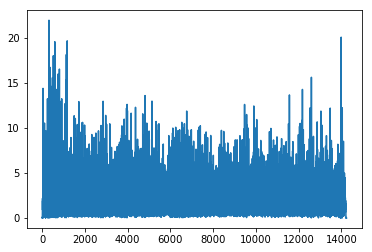

In [6]:
#4. Rhythm features - Tempogram

hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
plt.plot(oenv, label='Onset strength')

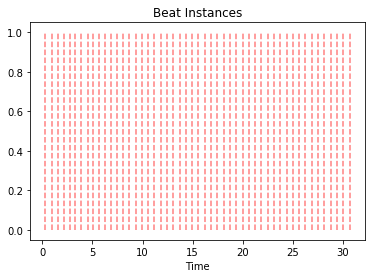

In [7]:
plt.vlines(beat_times[:50], 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats')
plt.title("Beat Instances")
plt.xlabel("Time")

### Extract Percussive Component 

In [8]:
 # Extract harmonic and percussive components
 y_harmonic, y_percussive = librosa.effects.hpss(y, margin=(1.0,5.0))

In [9]:
import IPython.display as ipd
print(y.shape)
#Play a bit of the song
ipd.Audio(y[500000:1000000], rate=sr) 

(7293072,)


In [10]:
#Play the percussive component
ipd.Audio(y_percussive[500000:1000000], rate=sr) 

### Extract Chroma Data

In [11]:
import librosa.display
chroma_cens = librosa.feature.chroma_cens(y=y[500000:1000000], sr=sr)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

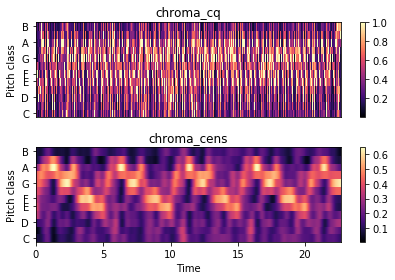

In [12]:
plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('chroma_cq')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()
plt.tight_layout()

## Repeat to a Few Frames of Training Data
First we load the expected song similarity rating that is from 0-4

In [37]:
import pandas as pd
df = pd.read_excel('Song Correlation.xlsx')

In [38]:
df.head()

Nirvana - Heart Shaped Box  \
Nirvana - Heart Shaped Box                                  4.0   
Alice in Chains - Rooster                                   NaN   
Chic - Le Freak                                             NaN   
Wild Cherry - Play that Funky Music                         NaN   
Snoop Dogg - who am i                                       NaN   

                                     Alice in Chains - Rooster  \
Nirvana - Heart Shaped Box                                 4.0   
Alice in Chains - Rooster                                  4.0   
Chic - Le Freak                                            NaN   
Wild Cherry - Play that Funky Music                        NaN   
Snoop Dogg - who am i                                      NaN   

                                     Chic - Le Freak  \
Nirvana - Heart Shaped Box                       2.0   
Alice in Chains - Rooster                        2.0   
Chic - Le Freak                                  4.0   
Wild Cherry - Play that Funky Music              NaN   
Snoop Dogg - who am i                            NaN   

                                     Wild Cherry - Play that Funky Music  \
Nirvana - Heart Shaped Box                                           2.0   
Alice in Chains - Rooster                                            2.0   
Chic - Le Freak                                                      4.0   
Wild Cherry - Play that Funky Music                                  4.0   
Snoop Dogg - who am i                                                NaN   

                                     Snoop Dogg - who am i  2Pac - can't c me  \
Nirvana - Heart Shaped Box                             0.0                0.0   
Alice in Chains - Rooster                              0.0                0.0   
Chic - Le Freak                                        1.0                0.0   
Wild Cherry - Play that Funky Music                    0.0                0.0   
Snoop Dogg - who am i                                  4.0                4.0   

                                     Chicago - 25 or 6 to 4  \
Nirvana - Heart Shaped Box                              2.0   
Alice in Chains - Rooster                               2.0   
Chic - Le Freak                                         1.0   
Wild Cherry - Play that Funky Music                     2.0   
Snoop Dogg - who am i                                   0.0   

                                     Green Day - Brain Stew  Beck G - Mayores  \
Nirvana - Heart Shaped Box                              3.0               0.0   
Alice in Chains - Rooster                               3.0               0.0   
Chic - Le Freak                                         1.0               1.0   
Wild Cherry - Play that Funky Music                     1.0               1.0   
Snoop Dogg - who am i                                   0.0               1.0   

                                     Maluma - Felices los 4  
Nirvana - Heart Shaped Box                                0  
Alice in Chains - Rooster                                 0  
Chic - Le Freak                                           1  
Wild Cherry - Play that Funky Music                       1  
Snoop Dogg - who am i                                     0

In [39]:
df.columns.values

array(['Nirvana - Heart Shaped Box', 'Alice in Chains - Rooster',
       'Chic - Le Freak', 'Wild Cherry - Play that Funky Music',
       'Snoop Dogg - who am i', "2Pac - can't c me",
       'Chicago - 25 or 6 to 4', 'Green Day - Brain Stew',
       'Beck G - Mayores', 'Maluma - Felices los 4'], dtype=object)

In [40]:
# Frame size 
nfft = 22050
print('Number of frames: ' + str(round(y.shape[0]/nfft)))

Number of frames: 331


In [41]:
x = []
for i, song in enumerate(df.columns.values):
    y, sr = librosa.load("music files/" + song + ".wav")
    
    # take frames to do calculations of the middle of a song, after any intros
    nframe = 60
    ycrop = y[nframe*nfft:(nframe+40)*nfft]
    
    # tempo features. Beat_frames are the samples where a strong beat occurs
    tempo, beat_frames = librosa.beat.beat_track(y=ycrop, sr=sr)
    # array beats is created so each song has the same length for x
    # beats = 0 unless a strong beat occurs at samples given from beat_frames
    beats = np.zeros((ycrop.shape))  
    beats[beat_frames] = 1            
    
    # percussive features
    y_percussive = librosa.effects.hpss(ycrop, margin=(1.0,5.0))[1]
    
    # chroma features
    chroma_cq = librosa.feature.chroma_cqt(y=ycrop, sr=sr)
    chroma_cq = np.ravel(chroma_cq) # flatten the 12 rows

    # predictor
    xi = np.hstack([sr, tempo, beats, y_percussive, chroma_cq])
    x.append(xi)
    

In [47]:
# beat times are not always the same length

xa = np.array(x)
print(x[9].shape)
#print(y_percussive.shape)
print(beat_frames)
beats = np.zeros((ycrop.shape))
beats[beat_frames] = 1
beats[25]

(1784678,)
[  11   25   39   53   66   80   94  108  121  135  149  163  177  190  204
  217  231  245  259  273  286  300  314  327  341  355  369  382  396  410
  424  437  451  465  479  492  506  520  534  547  561  575  589  603  616
  630  644  657  671  685  699  712  726  740  754  767  781  795  809  822
  836  851  866  881  896  911  926  940  954  968  981  995 1008 1022 1035
 1050 1064 1078 1092 1105 1119 1135 1152 1166 1180 1193 1207 1221 1235 1249
 1263 1277 1290 1303 1317 1331 1345 1359 1373 1386 1400 1413 1427 1441 1455
 1468 1482 1496 1510 1524 1538 1552 1565 1578 1592 1605 1619 1633 1647 1661
 1675 1688 1702]


1.0

In [55]:
# Columns = songs, Rows = Stacked features from sr to chroma

xdat = np.transpose(xa)
print(xdat.shape)

(1784678, 10)


In [60]:
# Y matrix listing likeness values (just extracted values from excel, not correct for neural network input)

y = np.array(df)
print(y)

[[  4.   4.   2.   2.   0.   0.   2.   3.   0.   0.]
 [ nan   4.   2.   2.   0.   0.   2.   3.   0.   0.]
 [ nan  nan   4.   4.   1.   0.   1.   1.   1.   1.]
 [ nan  nan  nan   4.   0.   0.   2.   1.   1.   1.]
 [ nan  nan  nan  nan   4.   4.   0.   0.   1.   0.]
 [ nan  nan  nan  nan  nan   4.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan   4.   3.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan   4.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan   4.   4.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan   4.]]


In [48]:
# Keras libraries

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [ ]:
# Data Splitting
# Splitting needs to be done for each type of musical feature
# Then overall training and test data matrices need to be reconstructed

In [49]:
# Keras Clear Session
import keras.backend as K
K.clear_session()

In [50]:
# Neural Network Model

print(xa.shape)
nin = xa.shape[0]
nh = 256
nout = 5 
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation = 'softmax',name='output'))

(10, 1784678)


In [ ]:
# Print Model Summary
model.summary()

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.loss = []
        self.val_acc = []
 
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        self.val_acc.append(logs.get('val_acc'))

# Create an instance of the history callback
history_cb = LossHistory()

In [ ]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts), callbacks=[history_cb])

In [59]:
   
    
    # testing stuff
    
    y, sr = librosa.load("music files/Nirvana -  Heart Shaped Box.wav")
    
    # Convert to floating point values so that compuations below do not overflow
y = y.astype(float)
    
    # take 2nd frame to do calculations of the middle of a song, after any intros
    # Frame size
nfft = 22050
    nframe = 2
    ycrop = y[nframe*nfft:(nframe+1)*nfft]
    


    

    



In [61]:
nfft = 22050
nframe = 60
ycrop = y[nframe*nfft:(nframe+40)*nfft]

In [62]:
    # tempo features
    tempo, beat_frames = librosa.beat.beat_track(y=ycrop, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)

In [63]:
    
    # percussive features
    y_percussive = librosa.effects.hpss(ycrop, margin=(1.0,5.0))[1]

In [58]:
print(y.shape)
print(y)
import IPython.display as ipd
print(y.shape)
#Play a bit of the song
ipd.Audio(y[60*nfft:100*nfft], rate=sr) 
#plt.plot(y[60*nfft:120*nfft])

(6266512,)
[ 0.  0.  0. ...,  0.  0.  0.]
(6266512,)


In [64]:
    # chroma features
    chroma_cq = librosa.feature.chroma_cqt(y=ycrop, sr=sr)

In [85]:
    print(tempo)
    print(beat_times.shape)
    print(y_percussive.shape)
    chroma_cq = np.ravel(chroma_cq)
    print(chroma_cq.shape)
    xtst = np.hstack([tempo, beat_times, y_percussive, chroma_cq])
    print(xtst.shape)


99.3840144231
(66,)
(882000,)
(20676,)
(902743,)


In [ ]:
val = []
for i, song in enumerate(df.columns.values):